# Chessboard pieces recognition

In [129]:
import pandas as pd
import numpy as np
import os
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

### Uploaded dataset was splitted localy with `partition_dataset.py`

### Download models from GitHub

In [21]:
!git clone https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


### Install object detection

In [22]:
%%bash
cd /kaggle/working/models/research
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /kaggle/working/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1679281 sha256=ab6d5b30c0499670c7ad33a1a5aa7477830d8e7b621199d30caf9ab0e9f1d599
  Stored in directory: /tmp/pip-ephem-wheel-cache-eb3vwahe/wheels/d3/e0/37/addaa349be05bc9a8e02e02876c3154afc70272d2a09a30920
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [23]:
#test install
!python ./models/research/object_detection/builders/model_builder_tf2_test.py

2021-11-03 12:02:54.015052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 12:02:54.121697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 12:02:54.122591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
Running tests under Python 3.7.10: /opt/conda/bin/python
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2021-11-03 12:02:54.236897: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-

In [24]:
labels = """item {
    id: 1
    name: 'wp'
}
item {
    id: 2
    name: 'bp'
}"""

with open('./label_map.pbtxt', 'w') as f:
    f.write(labels)
    f.close()

In [25]:
generate_tfrecord = '''""" Sample TensorFlow XML-to-TFRecord converter

usage: generate_tfrecord.py [-h] [-x XML_DIR] [-l LABELS_PATH] [-o OUTPUT_PATH] [-i IMAGE_DIR] [-c CSV_PATH]

optional arguments:
  -h, --help            show this help message and exit
  -x XML_DIR, --xml_dir XML_DIR
                        Path to the folder where the input .xml files are stored.
  -l LABELS_PATH, --labels_path LABELS_PATH
                        Path to the labels (.pbtxt) file.
  -o OUTPUT_PATH, --output_path OUTPUT_PATH
                        Path of output TFRecord (.record) file.
  -i IMAGE_DIR, --image_dir IMAGE_DIR
                        Path to the folder where the input image files are stored. Defaults to the same directory as XML_DIR.
  -c CSV_PATH, --csv_path CSV_PATH
                        Path of output .csv file. If none provided, then no file will be written.
"""

import os
import glob
import pandas as pd
import io
import xml.etree.ElementTree as ET
import argparse

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import tensorflow.compat.v1 as tf
from PIL import Image
from object_detection.utils import dataset_util, label_map_util
from collections import namedtuple

# Initiate argument parser
parser = argparse.ArgumentParser(
    description="Sample TensorFlow XML-to-TFRecord converter")
parser.add_argument("-x",
                    "--xml_dir",
                    help="Path to the folder where the input .xml files are stored.",
                    type=str)
parser.add_argument("-l",
                    "--labels_path",
                    help="Path to the labels (.pbtxt) file.", type=str)
parser.add_argument("-o",
                    "--output_path",
                    help="Path of output TFRecord (.record) file.", type=str)
parser.add_argument("-i",
                    "--image_dir",
                    help="Path to the folder where the input image files are stored. "
                         "Defaults to the same directory as XML_DIR.",
                    type=str, default=None)
parser.add_argument("-c",
                    "--csv_path",
                    help="Path of output .csv file. If none provided, then no file will be "
                         "written.",
                    type=str, default=None)

args = parser.parse_args()

if args.image_dir is None:
    args.image_dir = args.xml_dir

label_map = label_map_util.load_labelmap(args.labels_path)
label_map_dict = label_map_util.get_label_map_dict(label_map)


def xml_to_csv(path):
    """Iterates through all .xml files (generated by labelImg) in a given directory and combines
    them in a single Pandas dataframe.

    Parameters:
    ----------
    path : str
        The path containing the .xml files
    Returns
    -------
    Pandas DataFrame
        The produced dataframe
    """

    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        filename = root.find('filename').text
        width = int(root.find('size').find('width').text)
        height = int(root.find('size').find('height').text)
        for member in root.findall('object'):
            bndbox = member.find('bndbox')
            value = (filename,
                     width,
                     height,
                     member.find('name').text,
                     int(bndbox.find('xmin').text),
                     int(bndbox.find('ymin').text),
                     int(bndbox.find('xmax').text),
                     int(bndbox.find('ymax').text),
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def class_text_to_int(row_label):
    return label_map_dict[row_label]


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def main(_):

    writer = tf.python_io.TFRecordWriter(args.output_path)
    path = os.path.join(args.image_dir)
    examples = xml_to_csv(args.xml_dir)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())
    writer.close()
    print('Successfully created the TFRecord file: {}'.format(args.output_path))
    if args.csv_path is not None:
        examples.to_csv(args.csv_path, index=None)
        print('Successfully created the CSV file: {}'.format(args.csv_path))


if __name__ == '__main__':
    tf.app.run()'''

In [26]:
script = ''' """Sample TensorFlow XML-to-TFRecord converter

usage: generate_tfrecord.py [-h] [-x XML_DIR] [-l LABELS_PATH] [-o OUTPUT_PATH] [-i IMAGE_DIR] [-c CSV_PATH]

optional arguments:
  -h, --help            show this help message and exit
  -x XML_DIR, --xml_dir XML_DIR
                        Path to the folder where the input .xml files are stored.
  -l LABELS_PATH, --labels_path LABELS_PATH
                        Path to the labels (.pbtxt) file.
  -o OUTPUT_PATH, --output_path OUTPUT_PATH
                        Path of output TFRecord (.record) file.
  -i IMAGE_DIR, --image_dir IMAGE_DIR
                        Path to the folder where the input image files are stored. Defaults to the same directory as XML_DIR.
  -c CSV_PATH, --csv_path CSV_PATH
                        Path of output .csv file. If none provided, then no file will be written.
"""

import os
import glob
import pandas as pd
import io
import xml.etree.ElementTree as ET
import argparse

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import tensorflow.compat.v1 as tf
from PIL import Image
from object_detection.utils import dataset_util, label_map_util
from collections import namedtuple

# Initiate argument parser
parser = argparse.ArgumentParser(
    description="Sample TensorFlow XML-to-TFRecord converter")
parser.add_argument("-x",
                    "--xml_dir",
                    help="Path to the folder where the input .xml files are stored.",
                    type=str)
parser.add_argument("-l",
                    "--labels_path",
                    help="Path to the labels (.pbtxt) file.", type=str)
parser.add_argument("-o",
                    "--output_path",
                    help="Path of output TFRecord (.record) file.", type=str)
parser.add_argument("-i",
                    "--image_dir",
                    help="Path to the folder where the input image files are stored. "
                         "Defaults to the same directory as XML_DIR.",
                    type=str, default=None)
parser.add_argument("-c",
                    "--csv_path",
                    help="Path of output .csv file. If none provided, then no file will be "
                         "written.",
                    type=str, default=None)

args = parser.parse_args()

if args.image_dir is None:
    args.image_dir = args.xml_dir

label_map = label_map_util.load_labelmap(args.labels_path)
label_map_dict = label_map_util.get_label_map_dict(label_map)


def xml_to_csv(path):
    """Iterates through all .xml files (generated by labelImg) in a given directory and combines
    them in a single Pandas dataframe.

    Parameters:
    ----------
    path : str
        The path containing the .xml files
    Returns
    -------
    Pandas DataFrame
        The produced dataframe
    """

    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        filename = root.find('filename').text
        width = int(root.find('size').find('width').text)
        height = int(root.find('size').find('height').text)
        for member in root.findall('object'):
            bndbox = member.find('bndbox')
            value = (filename,
                     width,
                     height,
                     member.find('name').text,
                     int(bndbox.find('xmin').text),
                     int(bndbox.find('ymin').text),
                     int(bndbox.find('xmax').text),
                     int(bndbox.find('ymax').text),
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def class_text_to_int(row_label):
    return label_map_dict[row_label]


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def main(_):

    writer = tf.python_io.TFRecordWriter(args.output_path)
    path = os.path.join(args.image_dir)
    examples = xml_to_csv(args.xml_dir)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())
    writer.close()
    print('Successfully created the TFRecord file: {}'.format(args.output_path))
    if args.csv_path is not None:
        examples.to_csv(args.csv_path, index=None)
        print('Successfully created the CSV file: {}'.format(args.csv_path))


if __name__ == '__main__':
    tf.app.run()
'''

In [27]:
with open('./generate_tfrecord.py', 'w') as f:
    f.write(generate_tfrecord)
    f.close()

### Generate tfrecord for train adn test

In [28]:
!python generate_tfrecord.py -x /kaggle/input/chessview2/train -l ./label_map.pbtxt -o ./train.record

Successfully created the TFRecord file: ./train.record


In [29]:
!python generate_tfrecord.py -x /kaggle/input/chessview2/test -l ./label_map.pbtxt -o ./test.record

Successfully created the TFRecord file: ./test.record


### Download Pre-Trained Model

In [30]:
!wget -O ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

--2021-11-03 12:03:33--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.97.128, 2607:f8b0:400c:c18::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.97.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   165MB/s    in 1.4s    

2021-11-03 12:03:35 (165 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [31]:
!tar -xvf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/checkpoint
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.index
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/pipeline.config
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model/saved_model.pb
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model/assets/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model/variables/
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model/variables/variables.index


### Pipeline config

In [32]:
pipeline_config = '''model {
  ssd {
    num_classes: 2
    image_resizer {
      fixed_shape_resizer {
        height: 640
        width: 640
      }
    }
    feature_extractor {
      type: "ssd_resnet50_v1_fpn_keras"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 0.00039999998989515007
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.029999999329447746
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.996999979019165
          scale: true
          epsilon: 0.0010000000474974513
        }
      }
      override_base_feature_extractor_hyperparams: true
      fpn {
        min_level: 3
        max_level: 7
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    box_predictor {
      weight_shared_convolutional_box_predictor {
        conv_hyperparams {
          regularizer {
            l2_regularizer {
              weight: 0.00039999998989515007
            }
          }
          initializer {
            random_normal_initializer {
              mean: 0.0
              stddev: 0.009999999776482582
            }
          }
          activation: RELU_6
          batch_norm {
            decay: 0.996999979019165
            scale: true
            epsilon: 0.0010000000474974513
          }
        }
        depth: 256
        num_layers_before_predictor: 4
        kernel_size: 3
        class_prediction_bias_init: -4.599999904632568
      }
    }
    anchor_generator {
      multiscale_anchor_generator {
        min_level: 3
        max_level: 7
        anchor_scale: 4.0
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        scales_per_octave: 2
      }
    }
    post_processing {
      batch_non_max_suppression {
        score_threshold: 9.99999993922529e-09
        iou_threshold: 0.6000000238418579
        max_detections_per_class: 100
        max_total_detections: 100
        use_static_shapes: false
      }
      score_converter: SIGMOID
    }
    normalize_loss_by_num_matches: true
    loss {
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      classification_loss {
        weighted_sigmoid_focal {
          gamma: 2.0
          alpha: 0.25
        }
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    encode_background_as_zeros: true
    normalize_loc_loss_by_codesize: true
    inplace_batchnorm_update: true
    freeze_batchnorm: false
  }
}
train_config {
  batch_size: 4
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_crop_image {
      min_object_covered: 0.0
      min_aspect_ratio: 0.75
      max_aspect_ratio: 3.0
      min_area: 0.75
      max_area: 1.0
      overlap_thresh: 0.0
    }
  }
  sync_replicas: true
  optimizer {
    momentum_optimizer {
      learning_rate {
        cosine_decay_learning_rate {
          learning_rate_base: 0.03999999910593033
          total_steps: 25000
          warmup_learning_rate: 0.013333000242710114
          warmup_steps: 2000
        }
      }
      momentum_optimizer_value: 0.8999999761581421
    }
    use_moving_average: false
  }
  fine_tune_checkpoint: "./ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0"
  num_steps: 25000
  startup_delay_steps: 0.0
  replicas_to_aggregate: 8
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
  fine_tune_checkpoint_type: "detection"
  use_bfloat16: false
  fine_tune_checkpoint_version: V2
}
train_input_reader {
  label_map_path: "./label_map.pbtxt"
  tf_record_input_reader {
    input_path: "./train.record"
  }
}
eval_input_reader {
  label_map_path: "./label_map.pbtxt"
  shuffle: false
  num_epochs: 1
  tf_record_input_reader {
    input_path: "./test.record"
  }
}'''

In [33]:
with open('./pipeline.config', 'w') as f:
    f.write(pipeline_config)
    f.close()

In [34]:
!cp models/research/object_detection/model_main_tf2.py .

In [35]:
!python model_main_tf2.py --model_dir=models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8 --pipeline_config_path=./pipeline.config

2021-11-03 12:03:43.379594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 12:03:43.389325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 12:03:43.390110: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 12:03:43.391332: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [90]:
%%bash
mkdir trained_model
cp ./models/research/object_detection/exporter_main_v2.py ./trained_model/exporter_main_v2.py

In [91]:
%%bash
cd ./trained_model
python exporter_main_v2.py --input_type image_tensor --pipeline_config_path ../pipeline.config --trained_checkpoint_dir ../models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8  --output_directory ./chessview_model

2021-11-03 14:43:43.073799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 14:43:43.082917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 14:43:43.083632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 14:43:43.092225: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [121]:
%%bash
ls trained_model/chessview_model/

checkpoint
pipeline.config
saved_model


In [120]:
import shutil
shutil.make_archive('model', 'zip', 'trained_model/chessview_model/')

'/kaggle/working/model.zip'

### Predict

In [123]:
detect_fn = tf.saved_model.load('trained_model/chessview_model/saved_model')

2021-11-03 15:33:39.475138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 15:33:39.487006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 15:33:39.487868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-03 15:33:39.490353: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [172]:
image_np = np.array(Image.open('../input/chessview2/test/2021-10-30-040655.jpg'))
input_tensor = tf.convert_to_tensor(image_np)
input_tensor = input_tensor[tf.newaxis, ...]
detections = detect_fn(input_tensor)

In [173]:
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
detections['num_detections'] = num_detections
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
image_np_with_detections = image_np.copy()

Done


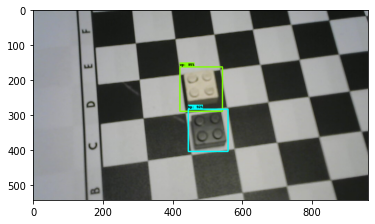

In [174]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

category_index = label_map_util.create_category_index_from_labelmap('./label_map.pbtxt',
                                                                    use_display_name=True)
viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

plt.figure()
plt.imshow(image_np_with_detections)
print('Done')
plt.show()

In [175]:
plt.imsave('chessview.jpg', image_np_with_detections)